# Generating random fly poses from neuromechfly

* put the fly in a random pose by setting its joint angles corresponding to normal ranges of motion for locomotion
* take an image from 7 different cameras, roughly corresponding to the locations of the septacam setup
* do some image processing so these images look somewhat similar to those taken from an IR camera
* get the locations of the end of the fly's limbs from the simulation

In [2]:
# use the EGL renderering backend and select the NVIDIA GPU to speed up rendering
%env MUJOCO_GL=egl
%env MUJOCO_EGL_DEVICE_ID=0

import numpy as np
import matplotlib.pyplot as plt
import imageio
import tqdm
from pathlib import Path
import cv2
import pandas as pd
import os

from flygym import Fly, Camera, SingleFlySimulation
from flygym.state.kinematic_pose import KinematicPose
from flygym.preprogrammed import all_leg_dofs
from flygym.arena import BaseArena

legs = [f"{side}{pos}" for side in "LR" for pos in "FMH"]
dofs_per_leg = [
	"Coxa",
	"Coxa_roll",
	"Coxa_yaw",
	"Femur",
	"Femur_roll",
	"Tibia",
	"Tarsus1",
]

class EmptyArena(BaseArena):
	def __init__(
		self,
	):
		super().__init__()

	def get_spawn_position(
		self, rel_pos: np.ndarray, rel_angle: np.ndarray
	) -> tuple[np.ndarray, np.ndarray]:
		return rel_pos, rel_angle

# from https://github.com/NeLy-EPFL/sequential-inverse-kinematics/blob/alfie_loc/notebooks/adapt_ik_to_locomotion_flytracker.ipynb
BOUNDS_LOCOMOTION = {
 'RF_Coxa_yaw': (np.deg2rad(-45), np.deg2rad(45)),
 'RF_Coxa': (np.deg2rad(-10), np.deg2rad(90)),
 'RF_Coxa_roll': (np.deg2rad(-135), np.deg2rad(10)),
 'RF_Femur': (np.deg2rad(-270), np.deg2rad(10)),
 'RF_Tibia': (np.deg2rad(-10), np.deg2rad(180)),
 'RF_Femur_roll': (np.deg2rad(-180), np.deg2rad(90)),
 'RF_Tarsus1': (np.deg2rad(-180), np.deg2rad(10)),

 'RM_Coxa_yaw': (np.deg2rad(-45), np.deg2rad(45)),
 'RM_Coxa': (np.deg2rad(-10), np.deg2rad(90)),
 'RM_Coxa_roll': (np.deg2rad(-180), np.deg2rad(10)),
 'RM_Femur': (np.deg2rad(-270), np.deg2rad(10)),
 'RM_Tibia': (np.deg2rad(-10), np.deg2rad(180)),
 'RM_Femur_roll': (np.deg2rad(-90), np.deg2rad(90)),
 'RM_Tarsus1': (np.deg2rad(-180), np.deg2rad(10)),

 'RH_Coxa_yaw': (np.deg2rad(-45), np.deg2rad(45)),
 'RH_Coxa': (np.deg2rad(-10), np.deg2rad(90)),
 'RH_Coxa_roll': (np.deg2rad(-180), np.deg2rad(10)),
 'RH_Femur': (np.deg2rad(-180), np.deg2rad(10)),
 'RH_Tibia': (np.deg2rad(-10), np.deg2rad(180)),
 'RH_Femur_roll': (np.deg2rad(-90), np.deg2rad(90)),
 'RH_Tarsus1': (np.deg2rad(-180), np.deg2rad(10)),

 'LF_Coxa_yaw': (np.deg2rad(-45), np.deg2rad(45)),
 'LF_Coxa': (np.deg2rad(-10), np.deg2rad(90)),
 'LF_Coxa_roll': (np.deg2rad(-10), np.deg2rad(90)),
 'LF_Femur': (np.deg2rad(-180), np.deg2rad(10)),
 'LF_Tibia': (np.deg2rad(-10), np.deg2rad(180)),
 'LF_Femur_roll': (np.deg2rad(-90), np.deg2rad(180)),
 'LF_Tarsus1': (np.deg2rad(-180), np.deg2rad(10)),

 'LM_Coxa_yaw': (np.deg2rad(-45), np.deg2rad(90)),
 'LM_Coxa': (np.deg2rad(-10), np.deg2rad(90)),
 'LM_Coxa_roll': (np.deg2rad(-10), np.deg2rad(180)),
 'LM_Femur': (np.deg2rad(-180), np.deg2rad(10)),
 'LM_Tibia': (np.deg2rad(-10), np.deg2rad(180)),
 'LM_Femur_roll': (np.deg2rad(-90), np.deg2rad(90)),
 'LM_Tarsus1': (np.deg2rad(-180), np.deg2rad(10)),

 'LH_Coxa_yaw': (np.deg2rad(-45), np.deg2rad(90)),
 'LH_Coxa': (np.deg2rad(-10), np.deg2rad(90)),
 'LH_Coxa_roll': (np.deg2rad(-10), np.deg2rad(180)),
 'LH_Femur': (np.deg2rad(-180), np.deg2rad(10)),
 'LH_Tibia': (np.deg2rad(-10), np.deg2rad(180)),
 'LH_Femur_roll': (np.deg2rad(-90), np.deg2rad(90)),
 'LH_Tarsus1': (np.deg2rad(-180), np.deg2rad(10))
}

env: MUJOCO_GL=egl
env: MUJOCO_EGL_DEVICE_ID=0


In [3]:
def rand_in_range(min: float, max: float):
	return np.random.random()*(max-min) + min

def hide_points_outisde_image(points: np.ndarray, image_size: tuple[int, ...]):
	"""Sets all points not within the bounds of an image size to NaN.

	- `points`: a 2xN array of (x,y) points within the image
	- `image_size`: size of the image (height, width)
	"""
	points[:,(points[0] < 0) | (points[1] < 0) | (points[0] > image_size[1]) | (points[1] > image_size[0])] = np.nan
	return points

def hide_points_that_camera_cant_see(points: np.ndarray, camera_num: int):
	if camera_num < 3: # camera sees the left side of the body
		points[:,3:] = np.nan
	elif camera_num > 3: # camera sees the right side of the body
		points[:,:3] = np.nan
	else: # camera in the middle sees the front two sets of legs
		points[:,(2,5)] = np.nan
	return points

def show_images(images: list[np.ndarray]):
	plt.figure(figsize=(30,10))
	plt.imshow(np.hstack(images), cmap='gray')
	plt.show()

def show_images_with_points(images: list[np.ndarray], points: list[np.ndarray]):
	plt.figure(figsize=(30,10))
	plt.imshow(np.hstack(images), cmap='gray')
	for camera_num, cam_points in enumerate(points):
		# cam_points = hide_points_that_camera_cant_see(hide_points_outisde_image(cam_points, images[0].shape), camera_num)
		cam_points = hide_points_outisde_image(cam_points, images[0].shape)
		plt.scatter(cam_points[0] + camera_num*images[0].shape[1], cam_points[1], c=range(points[0].shape[1]))
	plt.show()

def filter_image_to_greyscale(image: np.ndarray):
	"""Apply a filter so the image looks somewhat like it was taken from an IR camera."""
	return np.power(cv2.cvtColor(image, cv2.COLOR_BGR2GRAY), 1.1).clip(0,255).astype(np.uint8)

def set_fly_rand_pose(sim: SingleFlySimulation):
	pose = KinematicPose({
		f"joint_{leg}{dof}": rand_in_range(*BOUNDS_LOCOMOTION[f"{leg}_{dof}"])
		for leg in legs
		for dof in dofs_per_leg
	})
	# without resetting the context the pose of the fly doesn't get updated
	with sim.physics.reset_context():
		sim.fly.set_pose(pose, sim.physics)

def get_camera_images(sim: SingleFlySimulation) -> list[np.ndarray]:
	# we can directly call the mujoco camera's render method
	frames = [
		filter_image_to_greyscale(cam.dm_camera.render())
		for cam in sim.cameras
	]
	return frames

def get_end_effector_positions_in_cameras(sim: SingleFlySimulation) -> list[np.ndarray]:
	"""Get the 2d positions of the end effectors as a list of 2x6 numpy arrays, one for each camera."""
	points_list = []
	for cam in sim.cameras:
		# pad with ones to convert to homogeneous coordinates
		end_effector_positions = np.vstack((
			sim.fly.get_observation(sim)['end_effectors'].T,
			np.ones((1,sim.fly.n_legs))
		))
		# project the 3d positions onto the camera
		points = cam.dm_camera.matrix @ end_effector_positions
		# normalise by the z image coordinate
		points = points[:2] / points[2].reshape(1,-1)
		points_list.append(points)
	return points_list

def get_random_fly_position(sim: SingleFlySimulation):
	set_fly_rand_pose(sim)
	return get_camera_images(sim), get_end_effector_positions_in_cameras(sim)

In [4]:
# setup the fly in the 7 camera setup
fly = Fly(init_pose="stretch", actuated_joints=all_leg_dofs, control="position", xml_variant=Path("../flygym/data/mjcf/neuromechfly_seqik_kinorder_ypr_7cam.xml"))
cams = [
	Camera(fly=fly, camera_id=f"Animat/camera_{camera}", window_size=(960,640), play_speed=0.1, draw_contacts=False)
	for camera in range(7)
]
sim = SingleFlySimulation(fly=fly, cameras=cams, arena=EmptyArena(), timestep=1e-4, gravity=(0,0,0))

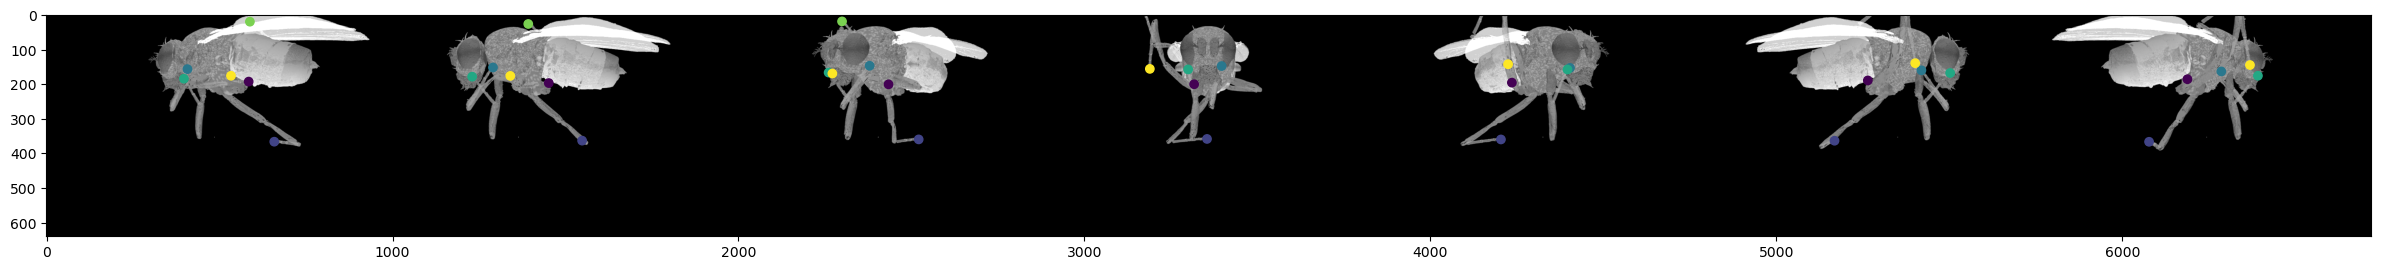

In [5]:
# check that we can get the fly in a random pose
show_images_with_points(*get_random_fly_position(sim))

In [5]:
LABELLER = "DD"

def save_frames_to_video(frames: list[list[np.ndarray]], output_dir: Path):
	for camera_num in range(len(frames[0])):
		with imageio.get_writer(output_dir / f"camera_{camera_num}.mp4") as writer:
			for frame_num in range(len(frames)):
				writer.append_data(frames[frame_num][camera_num])

def save_frames(frames: list[list[np.ndarray]], output_dir: Path):
	for frame_num in range(len(frames)):
		for camera_num in range(len(frames[0])):
			with imageio.get_writer(output_dir / f"camera_{camera_num}" / f"image_{frame_num}.png") as writer:
				writer.append_data(frames[frame_num][camera_num])

def points_to_deeplabcut_format(end_effector_locations: list[list[np.ndarray]]):
	"""Convert the points from each of the cameras into a dataframe that matches the deeplabcut format"""
	num_frames = len(end_effector_locations)
	num_cameras = len(end_effector_locations[0])
	joints = [f'tarsus-tip-{side}{leg}' for side in ['L','R'] for leg in [1,2,3]]
	# have data as frames * cameras * (x,y) * leg, but want it as cameras * frames * leg * (x,y)
	df = pd.DataFrame(np.array(end_effector_locations).transpose(1,0,3,2).reshape(-1,12),
		columns=pd.MultiIndex.from_product([[LABELLER], joints, ['x','y']], names=['scorer', 'bodyparts', 'coords']), 
		index=pd.MultiIndex.from_product([['labeled-data'], [f'camera_{cam}' for cam in range(num_cameras)], [f'image_{n}.png' for n in range(num_frames)]])
	)
	return df

def save_deeplabcut(df: pd.DataFrame, output_dir: Path):
	"""Save the annotations for each camera separately."""
	for camera_name in df.index.get_level_values(1).unique():
		camera_dir = output_dir / camera_name
		df.xs(camera_name, axis=0, level=1, drop_level=False).to_hdf(camera_dir / f'CollectedData_{LABELLER}.h5', key='annotations')

In [6]:
FRAMES_TO_GENERATE = 100

frames = []
points = []
for _ in tqdm.trange(FRAMES_TO_GENERATE):
	f, p = get_random_fly_position(sim)
	frames.append(f)
	points.append([hide_points_outisde_image(point, f[0].shape) for point in p])

100%|██████████| 100/100 [00:04<00:00, 22.39it/s]


In [7]:
output_dir = Path("./synthetic_data")
os.makedirs(output_dir, exist_ok=True)
for camera_num in range(len(sim.cameras)):
	os.makedirs(output_dir / f"camera_{camera_num}", exist_ok=True)

save_frames_to_video(frames, output_dir)
save_frames(frames, output_dir)
save_deeplabcut(points_to_deeplabcut_format(points), output_dir)

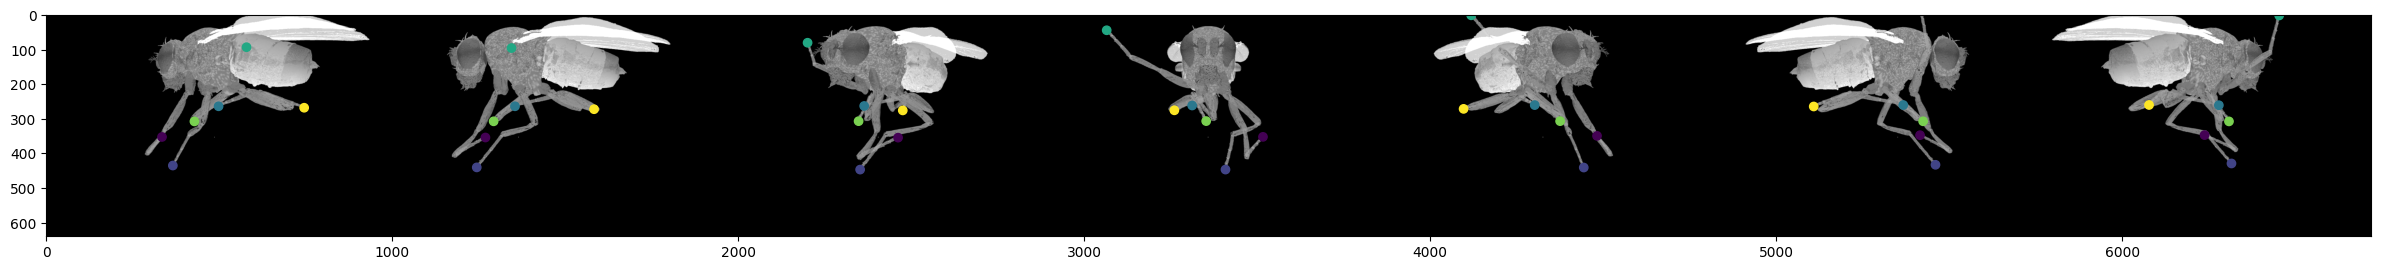

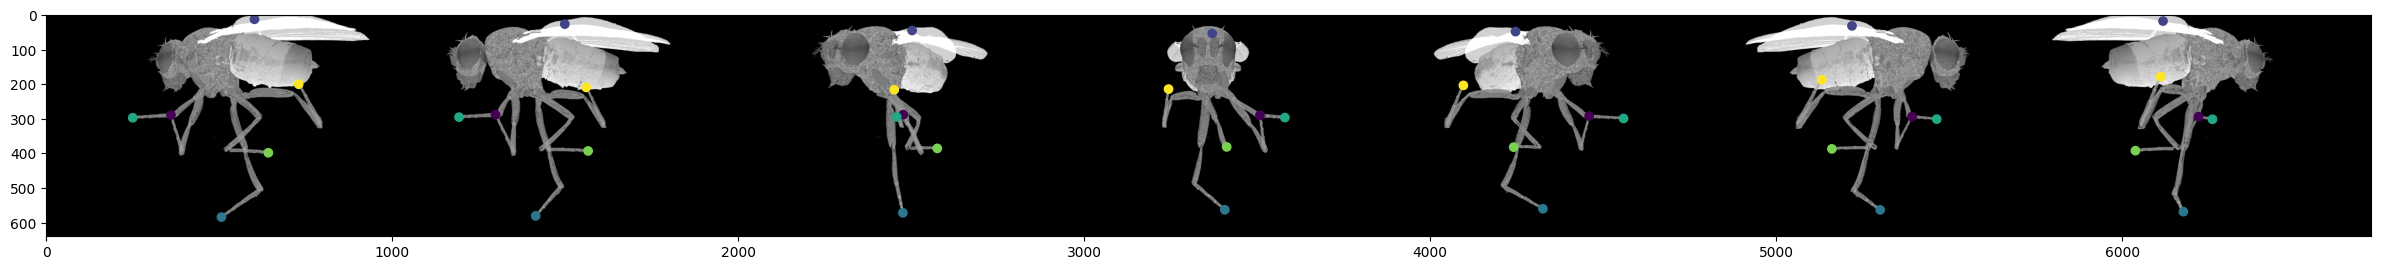

In [11]:
# sanity check the first and last frames
show_images_with_points(frames[0], points[0])
show_images_with_points(frames[99], points[99])

In [12]:
# check that the DLC data looks OK
pd.read_hdf(output_dir / "camera_0/CollectedData_DD.h5")

scorer                                        DD                            \
bodyparts                          tarsus-tip-L1             tarsus-tip-L2   
coords                                         x           y             x   
labeled-data camera_0 image_0.png     334.505654  352.437256    365.874176   
                      image_1.png     669.244665   59.072658    464.689327   
                      image_2.png     490.102958  340.577628    814.819672   
                      image_3.png     411.417268   89.178251    444.442316   
                      image_4.png     402.117677  187.859691    593.849664   
...                                          ...         ...           ...   
                      image_95.png    363.761011  305.745448    490.277517   
                      image_96.png    422.165586  227.509338    465.276536   
                      image_97.png    232.103700  195.433761    672.128618   
                      image_98.png    513.891754   10.659705    342.581764   
                      image_99.png    360.577765  289.016068    601.753864   

scorer                                                                    \
bodyparts                                      tarsus-tip-L3               
coords                                       y             x           y   
labeled-data camera_0 image_0.png   435.024838    498.035110  263.777158   
                      image_1.png    79.081615    735.883997  276.477351   
                      image_2.png    90.691533    350.838416  468.244717   
                      image_3.png   387.469441    371.890578  118.129235   
                      image_4.png    57.045093    372.478355  588.216748   
...                                        ...           ...         ...   
                      image_95.png  413.062434    429.327358  374.193564   
                      image_96.png  140.188106    472.716061  382.173104   
                      image_97.png  111.748158    539.961343  260.635132   
                      image_98.png  131.716213    519.145193   51.251416   
                      image_99.png   12.374407    506.309933  584.053278   

scorer                                                                      \
bodyparts                          tarsus-tip-R1             tarsus-tip-R2   
coords                                         x           y             x   
labeled-data camera_0 image_0.png     578.851999   93.003398    428.238437   
                      image_1.png     449.503876  345.438637    658.208255   
                      image_2.png     204.226510  181.424094    450.199841   
                      image_3.png     504.622183  311.106776    397.269917   
                      image_4.png     524.511540  286.285596    710.998841   
...                                          ...         ...           ...   
                      image_95.png    443.192837  119.702715    559.689653   
                      image_96.png    429.540905  272.149234           NaN   
                      image_97.png    660.045159  295.531206           NaN   
                      image_98.png    391.129882  226.576116    833.492916   
                      image_99.png    249.970751  296.929396    641.927762   

scorer                                                                    
bodyparts                                      tarsus-tip-R3              
coords                                       y             x           y  
labeled-data camera_0 image_0.png   307.491550    745.395710  267.966946  
                      image_1.png   120.924203    907.731027   48.049840  
                      image_2.png    79.062374    454.144140  102.919780  
                      image_3.png   167.149848    745.906514  327.045937  
                      image_4.png   177.087098    698.087663  426.898765  
...                                        ...           ...         ...  
                      image_95.png  258.466715    524.122505  385.374232  